In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
tf.__version__

'2.0.0'

In [2]:
"""Load the data and reshape to feed into CNN"""

train_data = np.array(pickle.load(open('data/SR-ARE-train/names_onehots.pickle', 'rb'))['onehots']).reshape(-1,70,325,1)
test_data = np.array(pickle.load(open('data/SR-ARE-test/names_onehots.pickle', 'rb'))['onehots']).reshape(-1,70,325,1)

print('Training data shape:', train_data.shape)
print('Testing data shape:', test_data.shape)


Training data shape: (7167, 70, 325, 1)
Testing data shape: (234, 70, 325, 1)


In [3]:
"""Get labels of each corresponding training and testing one hot vectors"""

def get_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [int(line.rstrip().split(',')[-1]) for line in f]
        f.close()
    return labels

train_labels = np.array(get_labels('data/SR-ARE-train/names_labels.txt'))
test_labels = np.array(get_labels('data/SR-ARE-test/names_labels.txt'))

print('Training labels shape:', train_labels.shape)
print('Testing labels shape:', test_labels.shape)

Training labels shape: (7167,)
Testing labels shape: (234,)


In [16]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def CNN(metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=train_data.shape[1:]),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(16, (3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        # keras.layers.Conv2D(32, (3,3), activation='relu'),
        # keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='tanh'),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.RMSprop(lr=0.001),
                  metrics=metrics)
    return model

def plot_loss(history, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train')
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n+1], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()

def plot_metrics(history):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[1], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [5]:
pos_data = []
neg_data = []

for i in range(len(train_data)):
    label = train_labels[i]
    data = train_data[i]
    if label == 0:
        neg_data.append(data)
    else:
        pos_data.append(data)

pos_labels = [1 for i in range(len(pos_data))]
neg_labels = [0 for i in range(len(neg_data))]

In [6]:
ids = np.arange(len(pos_data))
choices = list(np.random.choice(ids, len(neg_data)))

resampled_pos_data = np.array([pos_data[i] for i in choices])
resampled_pos_labels = np.array([pos_labels[i] for i in choices])

resampled_pos_data.shape

(6069, 70, 325, 1)

In [9]:
def train_val_split(features, label_class, VAL_SAMPLES=2000):
    all_ids = np.arange(len(features))
    
    val_ids = list(np.random.choice(all_ids, VAL_SAMPLES, replace=False))
    val_data = np.array([features[i] for i in val_ids])
    val_labels = [1 if label_class==1 else 0 for i in range(len(val_ids))]

    train_ids = list(set(all_ids)-set(val_ids))
    train_data = np.array([features[i] for i in train_ids])
    train_labels = [1 if label_class==1 else 0 for i in range(len(train_ids))]

    return [train_data, np.array(train_labels), val_data, np.array(val_labels)]

pos_TV_split = train_val_split(resampled_pos_data, 1)
neg_TV_split = train_val_split(neg_data, 0)

In [10]:
train_data = np.concatenate([pos_TV_split[0], neg_TV_split[0]], axis=0)
train_labels = np.concatenate([pos_TV_split[1], neg_TV_split[1]], axis=0)
val_data = np.concatenate([pos_TV_split[2], neg_TV_split[2]], axis=0)
val_labels = np.concatenate([pos_TV_split[3], neg_TV_split[3]], axis=0)

def shuffle(X, Y):
    order = np.arange(len(Y))
    np.random.shuffle(order)
    X = X[order]
    Y = Y[order]

shuffle(train_data, train_labels)
shuffle(val_data, val_labels)

print(train_data.shape)
print(val_data.shape)

(8138, 70, 325, 1)
(4000, 70, 325, 1)


In [17]:
model = CNN(output_bias=np.log(4855/4855))
model_history = model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels),verbose=1)

Train on 8138 samples, validate on 4000 samples
Epoch 1/10
  32/8138 [..............................] - ETA: 51:30

ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,34,161] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2DBackpropInput (defined at C:\Users\user\anaconda3\envs\tensor\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_61744]

Function call stack:
distributed_function


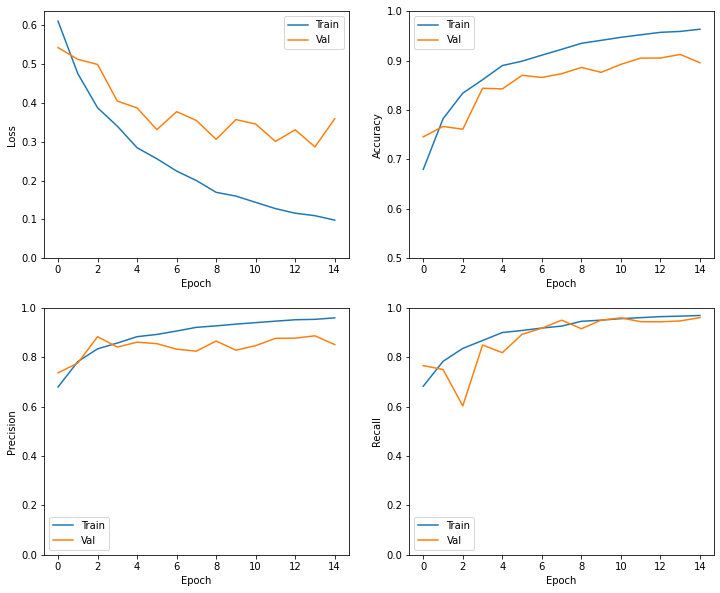

In [12]:
plot_metrics(model_history)

In [13]:
results = model.evaluate(test_data, test_labels, verbose=2)
print("Test Loss, Test Accuracy:", [results[0], results[-3]])


234/1 - 1s - loss: 1.3844 - tp: 25.0000 - fp: 55.0000 - tn: 131.0000 - fn: 23.0000 - accuracy: 0.6667 - precision: 0.3125 - recall: 0.5208
Test Loss, Test Accuracy: [1.489353560993814, 0.6666667]


In [12]:
# !mkdir saved_models
model.save('1155106843/saved_models/CNN_model2.h5')

In [45]:
predictions = model.predict(test_data.astype(np.float32))
# print(predictions)
stk = []
for i in predictions: 
    for j in i:
        if float(j) < 0.0005: output = 0
        else: output = 1
    stk.append(output)
